## Liver Disease: Object Detection

Dataset Source: https://huggingface.co/datasets/Francesco/liver-disease

#### Install Necessary Libraries

In [1]:
%pip install pip -U
%pip install torch torchivision datasets pytorch-lightning
%pip install transformers evaluate albumentations timm
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: Could not find a version that satisfies the requirement torchivision (from versions: none)
ERROR: No matching distribution found for torchivision
  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/21/02/ae8e595f45b6c8edee07913892b3b41f5f5f273962ad98851dc6a564bbb9/transformers-4.31.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.0 MB/s eta 0:00:00
  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4

#### Enter HuggingFace Access Token

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Import Necessary Libraries

In [3]:
import os, sys, random, shutil, re, json

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import PIL.Image

from tqdm import tqdm

import datasets
from datasets import load_dataset

import torch
import torchvision

import transformers
from transformers import AutoImageProcessor, TrainingArguments
from transformers import AutoModelForObjectDetection, Trainer

import albumentations

import evaluate

!git lfs install

Git LFS initialized.


##### Display Versions of Relevant Libraries

In [4]:
library_len = 14
version_len = 12

print(f"+{'-' * (library_len + version_len + 5)}+")
print("|", "Library".rjust(library_len), "|", "Version".ljust(version_len), "|")
print(f"|{'*' * (library_len + version_len + 5)}|")
print("|", "Python".rjust(library_len), "|", sys.version[0:6].ljust(version_len), "|")
print("|", "NumPy".rjust(library_len), "|", np.__version__.ljust(version_len), "|")
print("|", "Torch".rjust(library_len), "|", torch.__version__.ljust(version_len), "|")
print("|", "Torch Vision".rjust(library_len), "|", torchvision.__version__.ljust(version_len), "|")
print("|", "Datasets".rjust(library_len), "|", datasets.__version__.ljust(version_len), "|")
print("|", "Albumentations".rjust(library_len), "|", albumentations.__version__.ljust(version_len), "|")
print("|", "Transformer".rjust(library_len), "|", transformers.__version__.ljust(version_len), "|")
print("|", "Evaluate".rjust(library_len), "|", evaluate.__version__.ljust(version_len), "|")
print(f"+{'-' * (library_len + version_len + 5)}+")

+-------------------------------+
|        Library | Version      |
|*******************************|
|         Python | 3.10.1       |
|          NumPy | 1.22.4       |
|          Torch | 2.0.1+cu118  |
|   Torch Vision | 0.15.2+cu118 |
|       Datasets | 2.14.2       |
| Albumentations | 1.2.1        |
|    Transformer | 4.31.0       |
|       Evaluate | 0.4.0        |
+-------------------------------+


#### Load Dataset

In [5]:
data = load_dataset("Francesco/liver-disease")

data

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 2782
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 400
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 794
    })
})

#### Display Features for Sample

In [6]:
data['train'][12]

{'image_id': 1156,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'width': 640,
 'height': 640,
 'objects': {'id': [2873],
  'area': [14463],
  'bbox': [[471.0, 129.0, 142.5, 101.5]],
  'category': [2]}}

#### Define List of Category Names & Conversion Dictionaries

In [7]:
categories = data["train"].features["objects"].feature["category"].names

NUM_OF_CATEGORIES = len(categories)

id2label = {idx: tag for idx, tag in enumerate(categories)}
label2id = {tag: idx for idx, tag in enumerate(categories)}

print(f"List of Category Names:\n{categories}")
print(f"Number of Category Names: {NUM_OF_CATEGORIES}")
print(f"id2label:\n{id2label}")
print(f"label2id:\n{label2id}")

List of Category Names:
['diseases', 'ballooning', 'fibrosis', 'inflammation', 'steatosis']
Number of Category Names: 5
id2label:
{0: 'diseases', 1: 'ballooning', 2: 'fibrosis', 3: 'inflammation', 4: 'steatosis'}
label2id:
{'diseases': 0, 'ballooning': 1, 'fibrosis': 2, 'inflammation': 3, 'steatosis': 4}


#### Visualize A Sample

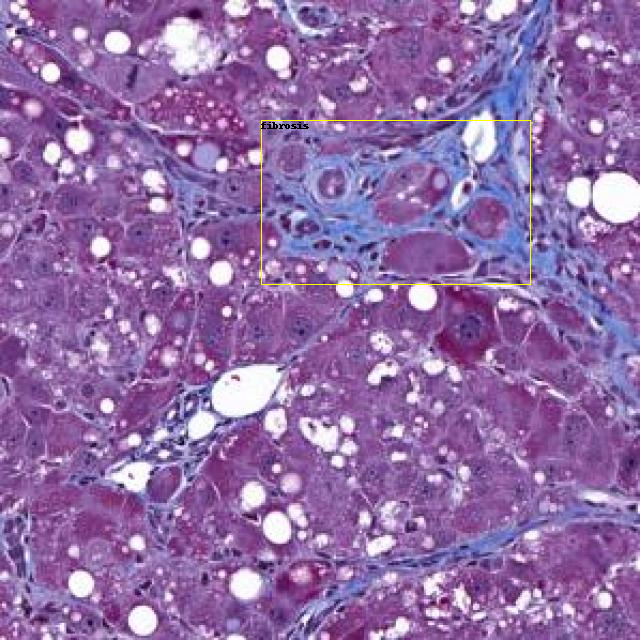

In [8]:
sample = data['train'][24]

sample_image = sample['image']
annotations = sample['objects']

draw = ImageDraw.Draw(sample_image)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="yellow", width=1)
    draw.text((x, y), id2label[class_idx], fill="black")

sample_image

#### Basic Values/Constants

In [9]:
MODEL_CKPT = "hustvl/yolos-small"
MODEL_NAME = f'{MODEL_CKPT.split("/")[-1]}-Liver_Disease'

LR = 1e-5
WEIGHT_DECAY = 1e-4

NUM_OF_EPOCHS = 10
BATCH_SIZE = 8

STRATEGY = "steps"
REPORTS_TO = "tensorboard"

#### Instantiate Image Processor

In [10]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_CKPT)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


#### Define Some Transformations for Images

In [11]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=['category']),
)

#### Create Function to Reformat Annotations Correctly

In [12]:
def reformat_annotations(image_id, category, area, bbox):
    annotations = []
    for x in range(0, len(category)):
        new_annotation = {
            "image_id": image_id,
            "category_id": category[x],
            "isCrowd": 0,
            "area": area[x],
            "bbox": list(bbox[x]),
        }
        annotations.append(new_annotation)

    return annotations

#### Combine Image & Annotation Transformations For Use On Batch of Samples

In [13]:
def transform_image_ann(samples):
    image_ids = samples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(samples["image"], samples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        { "image_id": id_, "annotations": reformat_annotations(id_, cat_, ar_, box_)
        } for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images,
                           annotations=targets,
                           return_tensors="pt")

#### Apply Image Transformations to Training Dataset

In [14]:
data['train'] = data['train'].with_transform(transform_image_ann)

data['train'][24]

{'pixel_values': tensor([[[ 1.0844,  1.1187,  1.1529,  ...,  1.8550,  1.9235,  1.9578],
          [ 1.2899,  1.3070,  1.3070,  ...,  1.8550,  1.9235,  1.9578],
          [ 1.6153,  1.5810,  1.5468,  ...,  1.8722,  1.9407,  1.9749],
          ...,
          [ 1.1015,  1.0844,  1.0673,  ...,  2.1462,  1.9407,  1.8037],
          [ 1.1187,  1.0673,  1.0331,  ...,  2.2147,  2.1290,  2.0777],
          [ 1.1187,  1.0673,  0.9988,  ...,  2.2489,  2.2489,  2.2489]],
 
         [[ 0.2402,  0.2752,  0.3102,  ...,  1.0280,  1.1155,  1.1681],
          [ 0.4503,  0.4678,  0.4678,  ...,  1.0455,  1.1155,  1.1681],
          [ 0.7654,  0.7479,  0.7129,  ...,  1.0630,  1.1331,  1.1681],
          ...,
          [ 0.0301,  0.0126, -0.0049,  ...,  1.5007,  1.2731,  1.1331],
          [ 0.0476,  0.0126, -0.0399,  ...,  1.7983,  1.6057,  1.4832],
          [ 0.0651,  0.0126, -0.0749,  ...,  1.9909,  1.8158,  1.7108]],
 
         [[ 1.3502,  1.3677,  1.4025,  ...,  1.4897,  1.5594,  1.5942],
          [ 

#### Define Data Collator

In [15]:
def data_collator_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch

#### Define Model

In [16]:
model = AutoModelForObjectDetection.from_pretrained(
    MODEL_CKPT,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([6, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define TrainingArguments

In [17]:
args = TrainingArguments(
    MODEL_NAME,
    auto_find_batch_size=True,
    num_train_epochs=NUM_OF_EPOCHS,
    logging_first_step=True,
    logging_strategy=STRATEGY,
    logging_steps=100,
    save_strategy=STRATEGY,
    save_steps=348,
    save_total_limit=12,
    remove_unused_columns=False,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Trainer

In [18]:
trainer = Trainer(
    model,
    args=args,
    data_collator=data_collator_fn,
    train_dataset=data['train'],
    tokenizer=image_processor,
)

Cloning https://huggingface.co/DunnBC22/yolos-small-Liver_Disease into local empty directory.


#### Train Model

In [19]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
1,3.731000
100,2.002900
200,1.858600
300,1.550400
400,1.503800
500,1.413400
600,1.409500
700,1.421500
800,1.323000
900,1.341200


TrainOutput(global_step=6960, training_loss=1.03100600448148, metrics={'train_runtime': 13256.3615, 'train_samples_per_second': 2.099, 'train_steps_per_second': 0.525, 'total_flos': 9.8234395264512e+18, 'train_loss': 1.03100600448148, 'epoch': 10.0})

#### Push Model To Hub

In [20]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/117M [00:00<?, ?B/s]

Upload file runs/Aug02_20-01-53_f595e40aafcb/events.out.tfevents.1691006527.f595e40aafcb.188.0:   0%|         …

To https://huggingface.co/DunnBC22/yolos-small-Liver_Disease
   d52fc8c..369e737  main -> main

   d52fc8c..369e737  main -> main

To https://huggingface.co/DunnBC22/yolos-small-Liver_Disease
   369e737..b024df4  main -> main

   369e737..b024df4  main -> main



'https://huggingface.co/DunnBC22/yolos-small-Liver_Disease/commit/369e7377aaa1f94d25f4fe2402dd262b4a139070'

#### Save Model

In [21]:
trainer.save_model()
trainer.save_state()

### Evaluate Model

#### Create Function to Reformat Evaluation Annotations Correctly

In [27]:
def eval_formatted_annotations(image_id, objects):
    annotations = []

    for x in range(0, len(objects["id"])):
        new_annotation = {
            "id": objects["id"][x],
            "category_id": objects["category"][x],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][x],
            "bbox": objects["bbox"][x],
        }
        annotations.append(new_annotation)

    return annotations

#### Define Data Collator

In [28]:
def eval_data_collator_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = eval_image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch

#### Mount Google Drive

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Save Images & Annotations into Proper Files

In [30]:
"""
Save images & annotations in format that
torchvision.datasets.CocoDetection expects
"""

def save_images_and_annotation_files(ds):
    output_json = {}
    path_output_ds = f"/content/drive/MyDrive/Projects/Liver Disease/data/"

    if not os.path.exists(path_output_ds):
        os.makedirs(path_output_ds)

    path_annotation = os.path.join(path_output_ds, "nfl_annos.json")
    categories_json = [
        {"supercategory" : "none", "id": id, "name": id2label[id]}
        for id in id2label]
    output_json['images'] = []
    output_json['annotations'] = []

    for sample in ds:
        anno = eval_formatted_annotations(sample["image_id"], sample["objects"])
        output_json["images"].append(
            {
                "id": sample["image_id"],
                "width": sample["image"].width,
                "height": sample["image"].height,
                "file_name": f"{sample['image_id']}.png",
            }
        )
        output_json["annotations"].extend(anno)
    output_json["categories"] = categories_json

    with open(path_annotation, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(ds["image"], ds["image_id"]):
        path_image = os.path.join(path_output_ds, f"{img_id}.png")
        im.save(path_image)

    return path_output_ds, path_annotation

#### Create Class to Ingest Datasets

In [31]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, annot_file):
        super().__init__(img_folder, annot_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.image_processor(images=img,
                                          annotations=target,
                                          return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return {"pixel_values": pixel_values, "labels": target}

#### Apply Above-Defined Functions to Dataset

In [32]:
EVAL_MODEL_NAME = f'DunnBC22/yolos-small-Liver_Disease'

eval_image_processor = AutoImageProcessor.from_pretrained(EVAL_MODEL_NAME)

path_output_ds, path_annot = save_images_and_annotation_files(data["validation"])
eval_ds_coco_format = CocoDetection(path_output_ds,
                                    eval_image_processor,
                                    path_annot)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


#### Calculate Metrics

In [33]:
model = AutoModelForObjectDetection.from_pretrained(EVAL_MODEL_NAME)

module = evaluate.load("ybelkada/cocoevaluate",
                       coco=eval_ds_coco_format.coco)

eval_dataloader = torch.utils.data.DataLoader(
    eval_ds_coco_format,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=data_collator_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(eval_dataloader)):
        pixel_values = batch["pixel_values"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]

        # forward pass
        outputs = model(pixel_values=pixel_values)

        orig_target_sizes = torch.stack(
            [
                target["orig_size"] for target in labels
            ],
            dim=0)

        results = eval_image_processor.post_process(outputs,
                                                    orig_target_sizes)

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 50/50 [57:46<00:00, 69.32s/it]


Accumulating evaluation results...
DONE (t=0.40s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.254
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.283
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

#### Display Metrics

In [35]:
import pandas as pd

pd.DataFrame(results)

,iou_bbox
AP-IoU=0.50-area=all-maxDets=100,0.398811
AP-IoU=0.50:0.95-area=all-maxDets=100,0.254417
AP-IoU=0.50:0.95-area=large-maxDets=100,0.283016
AP-IoU=0.50:0.95-area=medium-maxDets=100,0.153823
AP-IoU=0.50:0.95-area=small-maxDets=100,0.000000
AP-IoU=0.75-area=all-maxDets=100,0.290713
AR-IoU=0.50:0.95-area=all-maxDets=1,0.147376
AR-IoU=0.50:0.95-area=all-maxDets=10,0.450945
AR-IoU=0.50:0.95-area=all-maxDets=100,0.551596
AR-IoU=0.50:0.95-area=large-maxDets=100,0.572365


### Notes & Other Takeaways
****
- In order to optimize this model, I think this project needs between 20 and 25 epochs.

****

### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}


- Dataset
    > @misc{ liver-disease, title = { liver disease Dataset }, type = { Open Source Dataset }, author = { Roboflow 100 }, howpublished = { \url{ https://universe.roboflow.com/object-detection/liver-disease } }, url = { https://universe.roboflow.com/object-detection/liver-disease }, journal = { Roboflow Universe }, publisher = { Roboflow }, year = { 2022 }, month = { nov }, note = { visited on 2023-03-29 },}
